In [76]:
import wandb
import os 

os.environ['WANDB_NOTEBOOK_NAME'] = 
%env WANDB_API_KEY = 

wandb.login()

env: WANDB_API_KEY=32ba2dfcae28d5229d9da5ea919130a28f8ab52c


True

In [77]:
import torch
import matplotlib.pyplot as plt


In [78]:
from utils import (
    save_checkpoint,
    load_checkpoint,
    check_accuracy,
    save_test_images,
    get_loaders,
    plot_image_mask_pred,
    plot_image_mask_box_pred_box_tolerance,
    get_largest_segments_bounding_box, 
    plot_image_mask_box_pred_box
)

from models import UNET
from monai.networks.nets import UNet

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [79]:
import matplotlib.patches as patches
from copy import copy

def calculate_cropped_area_with_tolerance(model, test_image, test_mask, tolerance, device="cuda"):
    x = test_image.to(device)
    preds = model(x)
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    gt_box = get_largest_segments_bounding_box(test_mask)[0]
    pred_box = get_largest_segments_bounding_box(preds.cpu())[0]

    # Coordinates for the predicted box and ground truth box
    x1_pred, y1_pred, x2_pred, y2_pred = pred_box

    # Add tolerance
    x1_pred, y1_pred, x2_pred, y2_pred = x1_pred - tolerance, y1_pred - tolerance, x2_pred + tolerance, y2_pred + tolerance

    # Calculate area of predicted box and ground truth box
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)

    total_area = 195*195

    return pred_area / total_area


In [80]:
Own_unet = UNET(in_channels=1, out_channels=1, features= [16, 32, 64, 128]).to(DEVICE)
load_checkpoint(Own_unet, f'/home/alex/Documents/new try/Data/Lung Unet/save_states/Own_Unet_gaussian_10.pth.tar')#r'/home/alex/Documents/new try/Data/Lung Unet/save_states/Own_unet_padding_2.pth.tar')
Monai_unet = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=(16, 32, 64, 128), strides=(2, 2, 2), bias = False, num_res_units = 0).to(device=DEVICE)
load_checkpoint(Monai_unet, r'/home/alex/Documents/new try/Data/Lung Unet/save_states/Monai_Unet_gaussian1_0.pth.tar')

model = Own_unet

from simulated_lung_dataset_gaussian import get_loaders_simulated
train_loader, test_loader, validation_loader = get_loaders_simulated(batch_size = 1)

=> Loading checkpoint
=> Loading checkpoint


In [81]:
test_loader_iter = iter(test_loader)

image, mask = next(test_loader_iter)

calculate_cropped_area_with_tolerance(model, image, mask, 10)

tensor(0.6263)

In [82]:
reduced_areas = []
tolerance = 0

for image, mask in test_loader:
    reduced_area = 1 - calculate_cropped_area_with_tolerance(model, image, mask, tolerance = tolerance, device="cuda")
    reduced_areas.append(reduced_area)

In [83]:
import numpy as np
mean = np.mean(reduced_areas)
std = np.std(reduced_areas)
print(mean, std)

0.4897482 0.07096529


In [84]:
reduced_areas = 100* np.array(reduced_areas)

48.97482


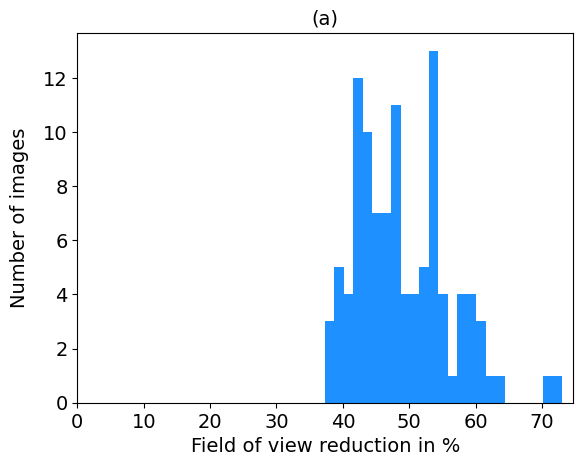

In [85]:
print(np.mean(reduced_areas))
plt.hist(reduced_areas, bins = 25, color = 'dodgerblue')#, range = (0, 0.5))
plt.xticks(np.arange(0, 80, step= 10))
plt.xlabel('Field of view reduction in %', size = 14)
plt.ylabel('Number of images', size = 14, labelpad=10) 
plt.title('(a)', size = 14)
plt.tick_params(axis='both', labelsize=14)
#plt.savefig(r'/home/alex/Documents/Images_thesis/our_unet_fov_reduction_without_tolerance.svg', bbox_inches="tight", format="svg")
plt.show()

In [86]:
reduced_areas = []
tolerance = 10

for image, mask in test_loader:
    reduced_area = 1 - calculate_cropped_area_with_tolerance(model, image, mask, tolerance = tolerance, device="cuda")
    reduced_areas.append(reduced_area)

reduced_areas = 100* np.array(reduced_areas)

33.41313


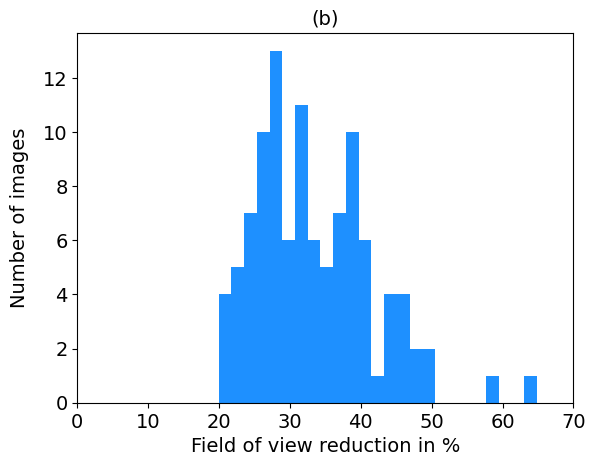

In [87]:
print(np.mean(reduced_areas))
plt.hist(reduced_areas, bins = 25, color = 'dodgerblue')#, range = (0, 0.5))
plt.xticks(np.arange(0, 80, step= 10))
plt.xlabel('Field of view reduction in %', size = 14)
plt.ylabel('Number of images', size = 14, labelpad=10) 
plt.title('(b)', size = 14)
plt.tick_params(axis='both', labelsize=14)
#plt.savefig(r'/home/alex/Documents/Images_thesis/our_unet_fov_reduction_with_tolerance.svg', bbox_inches="tight", format="svg")
plt.show()